In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../nonlin')
sys.path.append('../partion')
sys.path.append('../1D-difusion')

from aspen import aspen
from newton import newton

import partion
from partion import metrics1, metrics2, m1, m2, m3
import wrapper

from one_phase import one_phase
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def model(u):
    return np.array([u**2+1, 2*max(u, 0)])

class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

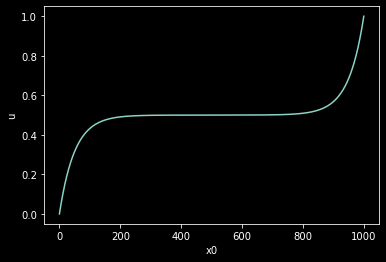

In [3]:
plt.style.use('dark_background')
# inital condition
Nx = 1000
Nt = 100

D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)
bd1 = 0
bd2 = 1

x0 = np.arange(Nx)/(Nx-1)
x0 = np.sinh(20*(x0-0.5))
x0 /= np.max(x0)
x0 = (x0+1)/2
x0 = np.reshape(x0, (-1, 1))
plt.xlabel('x0')
plt.ylabel('u')
plt.plot(x0)

setInitial = lambda x: x#.setInitial(0.2, 1, 1) 
setSources = lambda x: x#.setSources([0.9], [-17.9])

In [4]:
test = wrapper.test_decorator(wrapper.test)

In [6]:
param = {
    'Nx': Nx, 
    'Nt': Nt,
}
nl_solver = newton(1e-2, kmax = 14, crit_abs = 1e-3)
solver_cl = one_phase(param, D, nl_solver)
solver_cl.setBoundary(bd1, bd2)
solver_cl.x0 = np.copy(x0)
X_cl, message, t_new = test(solver_cl, x0, sample_size=1)

test started
verdict : OK
mean time : 63.26792240142822
mean newton iterations:  4.11


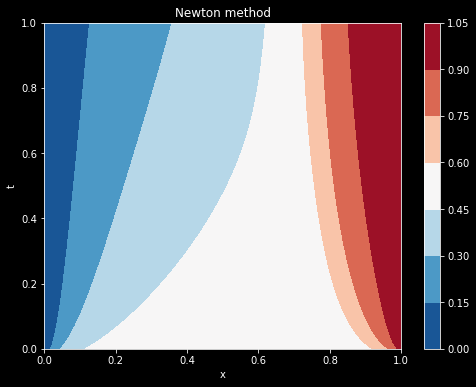

In [7]:
wrapper.show_res(solver_cl)

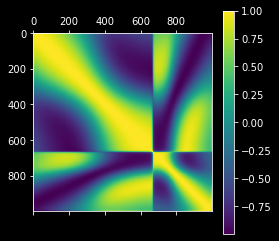

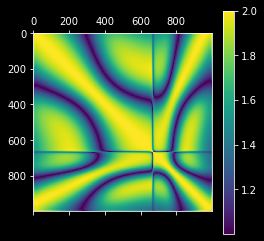

In [8]:
# we treet the value in time at particular coord as a variable
# let's visualize the correlation matrix of these varibles

cov_m = np.cov(X_cl[:, 1:]-X_cl[:, :-1])

for i in range(Nx):
    tmp = cov_m[i, i]
    cov_m[:, i] /= np.sqrt(tmp)
    cov_m[i, :] /= np.sqrt(tmp)

cs = plt.matshow(cov_m)
cbar = plt.colorbar(cs)
plt.show()
cov_m = np.abs(cov_m)
cs = plt.matshow(1+cov_m)
cbar = plt.colorbar(cs)
plt.show()

Хм... а вот "разрез" в матрице соответсвует участку, что мало менялся на всем промежутке времени (можно увидеть на графике). Тем не менее матрица имеет сильно ненулевые элементы в углах, что никак не соответсвует связанности доменов, в силу наличия "разреза". Следовательно, использование такой матрицы в целях разбиения - сомнительно 

In [30]:
from sklearn.cluster import KMeans
Nd = 4
X = np.concatenate((np.linspace(0, 1, Nx).reshape(-1, 1), X_cl), axis = 1)
#X = X_cl
kmeans = KMeans(n_clusters=Nd, random_state = 0).fit(X)
a = kmeans.labels_
borders = []
for i in range(1, Nx):
    if a[i] != a[i-1]:
        borders.append(i)
borders = np.concatenate(([0], borders, [Nx]))
print(borders)

[   0  206  694  829 1000]


In [31]:
Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt
}
nl_solver = aspen(Nd, borders, 1e-2, crit_abs = 1e-3)
solver = one_phase(param, D, nl_solver)
solver.x0 = np.copy(x0)
solver.setBoundary(bd1, bd2)
X, message, t = test(solver, x0, sample_size = 5)

test started
verdict : OK
mean time : 43.08807191848755
mean aspen iterations:  1.0


--time comparision--
newton : 63.08207607269287
aspen, clustering : 43.30762028694153


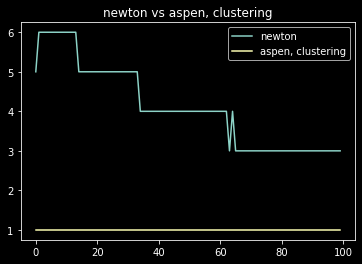

iters : [6.11 1.   1.   1.01]


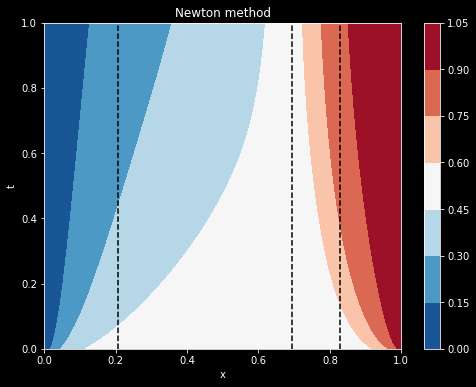

In [32]:
wrapper.compare([solver_cl, solver], ['newton', 'aspen, clustering'])
wrapper.show_res(solver)

Метод получисля на удивление рабочим. Результат лучше всех, полученных в Test1 для числа доменов - 4. Возможно имеет смысл равняться на него в построении метрик.

In [34]:
from sklearn.cluster import KMeans
Nd = 5
X = np.concatenate((np.linspace(0, 1, Nx).reshape(-1, 1), X_cl), axis = 1)
#X = X_cl
kmeans = KMeans(n_clusters=Nd, random_state = 0).fit(X)
a = kmeans.labels_
borders = []
for i in range(1, Nx):
    if a[i] != a[i-1]:
        borders.append(i)
borders = np.concatenate(([0], borders, [Nx]))
print(borders)

[   0  128  390  740  853 1000]


In [37]:
Nd = 5
param = {
    'Nx': Nx, 
    'Nt': Nt
}
nl_solver = aspen(Nd, borders, 1e-2, crit_abs = 1e-3)
solver = one_phase(param, D, nl_solver)
solver.x0 = np.copy(x0)
solver.setBoundary(bd1, bd2)
X, message, t = test(solver, x0, sample_size = 5)

test started
verdict : OK
mean time : 44.588902187347415
mean aspen iterations:  1.19


--time comparision--
newton : 63.08207607269287
aspen, clustering : 46.35692358016968


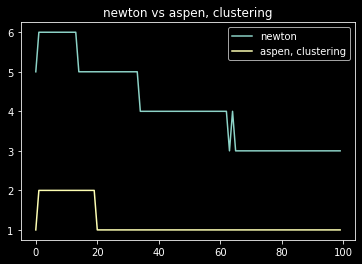

iters : [8.31 1.15 1.   1.19 1.2 ]


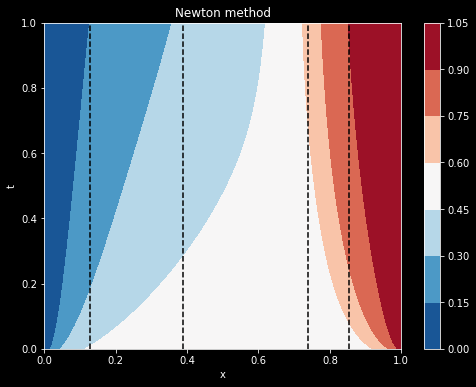

In [39]:
wrapper.compare([solver_cl, solver], ['newton', 'aspen, clustering'])
wrapper.show_res(solver)